In [56]:
import pandas as pd
from Bio import SeqIO
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [57]:
allseqs = list(SeqIO.parse('allseqs.fasta', 'fasta'))

In [58]:
len(allseqs)

410768

In [59]:
allseqs_mapped = {x.id: x for x in allseqs}
len(allseqs_mapped)

410768

In [60]:
seqMasterKey = pd.read_csv('ClustDBTSV.tsv', sep='\t', header=None, names=['Cluster', 'SequenceId'])
seqMasterKey

,Cluster,SequenceId
0,nontox-omWr3L,nontox-omWr3L
1,nontox-omWr3L,nontox-U42kPM
2,nontox-omWr3L,nontox-rzBfU4
3,nontox-omWr3L,nontox-nnHGIb
4,nontox-omWr3L,nontox-PmUwlh
...,...,...
410763,nontox-euVuBJ,nontox-ofFbKS
410764,nontox-euVuBJ,nontox-UML8dE
410765,nontox-k9rFgy,nontox-k9rFgy
410766,nontox-34o3qH,nontox-34o3qH


In [61]:
clustered_seqs = {}
for index, row in seqMasterKey.iterrows():
    curr_clust = row['Cluster']
    if curr_clust in clustered_seqs:
        clustered_seqs[curr_clust] += [allseqs_mapped[row['SequenceId']]]
    else:
        clustered_seqs[curr_clust] = [allseqs_mapped[row['SequenceId']]]
print(len(clustered_seqs))

88031


In [62]:
len(seqMasterKey['Cluster'].unique())

88031

In [63]:
cluster_sizes = [len(clustered_seqs[x]) for x in clustered_seqs]
avg_len = np.mean(cluster_sizes)
median_len = np.median(cluster_sizes)
print(avg_len)
print(median_len)


4.6661744158307865
1.0


In [64]:
print(f'Total Clusters: {len(clustered_seqs)}')


Total Clusters: 88031


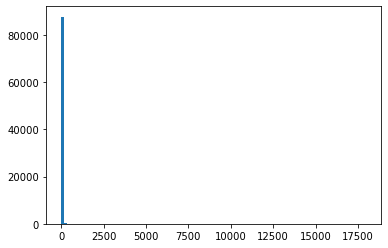

In [17]:
plt.figure()
plt.hist(cluster_sizes, bins=100)
plt.show()

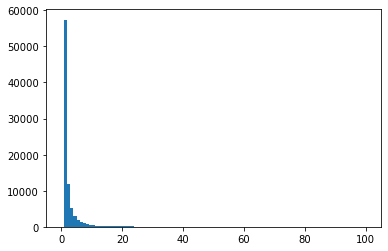

In [19]:
plt.figure()
plt.hist(cluster_sizes, bins=100, range=(0, 100))
plt.show()

In [65]:
clustersizes_np = np.array(cluster_sizes)

In [66]:
sum((clustersizes_np > 10) * 1.0)/len(clustersizes_np)

0.05100475968692847

# Train Test Split Creation Algorithm

So, here's our goal: we want to make sure that clusters are segregated to either the train set or the test set. We also want to make sure that the proportion of toxin and nontoxins is the same too.

In [67]:
clustered_seqs_pos = {
    k: sum([1 for s in v if s.id[:3] == 'tox']) for k, v in clustered_seqs.items()
}
clustered_seqs_neg = {
    k: sum([1 for s in v if s.id[:3] == 'non']) for k, v in clustered_seqs.items()
}
clustered_seqs_total = {
    k: len(v) for k, v in clustered_seqs.items()
}

In [68]:
clustered_seqs_keys = list(clustered_seqs_total.keys())
clustered_seqs_counts = np.array(list(clustered_seqs_total.values()))
clustered_sort_indx = np.argsort(clustered_seqs_counts)[::-1]
clustered_seqs_keys_sorted = [clustered_seqs_keys[i] for i in clustered_sort_indx]
print(clustered_seqs_keys_sorted[:10])

['tox-bSbnW4', 'tox-gHiywl', 'tox-Oew6tZ', 'tox-rQqgdE', 'tox-xi0RE2', 'tox-kWWac6', 'tox-cDRLkx', 'tox-TR42cT', 'tox-JZb8Qu', 'tox-0wTQ70']


In [69]:
clustered_seqs_total['tox-bSbnW4']

17955

In [70]:
train_set = []
train_set_pos = 0
train_set_neg = 0

test_set = []
test_set_pos = 0
test_set_neg = 0

target_train_test_prcnt = 0.9
target_train_pos = 0.5
target_test_pos = 0.5

for k in clustered_seqs_keys_sorted:
    seq_set = clustered_seqs[k]
    seq_total_cnt = clustered_seqs_total[k]
    seq_pos_cnt = clustered_seqs_pos[k]
    seq_neg_cnt = clustered_seqs_pos[k]
        
    train_prcnt_w_seq = (len(train_set) + seq_total_cnt) / (len(train_set) + seq_total_cnt + len(test_set))
    train_prcnt_pos_w_seq = (train_set_pos + seq_pos_cnt) / (train_set_pos + seq_pos_cnt + train_set_neg + seq_neg_cnt)
    if_train_loss = (train_prcnt_w_seq - target_train_test_prcnt) ** 2 + (train_prcnt_pos_w_seq - target_train_pos) ** 2
    
    test_prcnt_w_seq = (len(test_set) + seq_total_cnt) / (len(test_set) + seq_total_cnt + len(train_set))
    test_prcnt_pos_w_seq = (test_set_pos + seq_pos_cnt) / (test_set_pos + seq_pos_cnt + test_set_neg + seq_neg_cnt)
    if_test_loss = (test_prcnt_w_seq - (1 - target_train_test_prcnt)) ** 2 + (test_prcnt_pos_w_seq - target_test_pos) ** 2
    
    if if_train_loss > if_test_loss:
        test_set += seq_set
        test_set_pos += seq_pos_cnt
        test_set_neg += seq_neg_cnt
    else:
        train_set += seq_set
        train_set_pos += seq_pos_cnt
        train_set_neg += seq_neg_cnt

print(f"Train Set Size: {len(train_set)}\nTrain Positives: {train_set_pos}\nTrain Negatives: {train_set_neg}\n\n")
print(f"Test Set Size: {len(test_set)}\nTest Positives: {test_set_pos}\nTest Negatives: {test_set_neg}\n\n")
print(f"Train / Test Proportion: {len(train_set)/(len(train_set) + len(test_set))}")
print(f"Train Percent Pos: {train_set_pos / (train_set_pos + train_set_neg)}")
print(f"Test Percent Pos: {test_set_pos / (test_set_pos + test_set_neg)}")

Train Set Size: 369691
Train Positives: 184336
Train Negatives: 184336


Test Set Size: 41077
Test Positives: 21048
Test Negatives: 21048


Train / Test Proportion: 0.8999995131071554
Train Percent Pos: 0.5
Test Percent Pos: 0.5


In [71]:
train_set_toxins = [x for x in train_set if x.id[:3] == 'tox']
train_set_nontoxins = [x for x in train_set if x.id[:3] == 'non']
test_set_toxins = [x for x in test_set if x.id[:3] == 'tox']
test_set_nontoxins = [x for x in test_set if x.id[:3] == 'non']

In [72]:
print(len(train_set_toxins))
print(len(train_set_nontoxins))
print(len(test_set_toxins))
print(len(test_set_nontoxins))

184336
185355
21048
20029


In [73]:
SeqIO.write(train_set_toxins, 'train-toxins.fasta', 'fasta')
SeqIO.write(train_set_nontoxins, 'train-nontoxins.fasta', 'fasta')
SeqIO.write(test_set_toxins, 'test-toxins.fasta', 'fasta')
SeqIO.write(test_set_nontoxins, 'test-nontoxins.fasta', 'fasta')

20029